In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from matplotlib.colors import ListedColormap
import jax.numpy as jnp
import initialize_nets
import reaction_nets
import jax
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt, PIDController, Kvaerno3

In [38]:
jax.config.update("jax_enable_x64", True)

In [39]:
file=open('data/test/triangle_b_double_non_monotonic_test_data', 'rb')
test_data=pkl.load(file)
file.close()

In [40]:
val_features, val_labels, pred_labels=test_data['val_features'],test_data['val_labels'], test_data['pred_labels']

In [41]:
file=open('data/train/triangle_b_double_non_monotonic_training_data', 'rb')
train_data=pkl.load(file)
file.close()

In [42]:
optimized_params, loss_history, grads_per_epoch_autodiff=train_data['optimized_params'], train_data['loss_history'], train_data['grads_per_epoch_autodiff']

In [43]:
init_data_file='data/init_data/triangle_b_double_non_monotonic'
num_epochs =  3 #20 
t_points = jnp.linspace(0.0, 10.0, 100) 

#read in training and network info

file = open(init_data_file, 'rb')
init_data_dict=pkl.load(file)
file.close()

net_type, initial_params, t_points, train_features, train_labels, initial_conditions, true_params, training_data_type, train_features, train_labels, val_features, val_labels=init_data_dict['network_type'], init_data_dict['initial_params'], init_data_dict['t_points'], init_data_dict['train_features'], init_data_dict['train_labels'], init_data_dict['initial_conditions'], init_data_dict['true_params'], init_data_dict['training_data_type'], init_data_dict['train_features'], init_data_dict['train_labels'], init_data_dict['val_features'], init_data_dict['val_labels']

In [44]:
solver=Tsit5()
stepsize_controller=PIDController(0.005, 0.01)
t_points=jnp.linspace(0.0, 10.0, 100)
dt0=0.001
max_steps=10000

In [45]:
rxn=reaction_nets.rxn_net(net_type)

Checking that the training data profile looks correct.

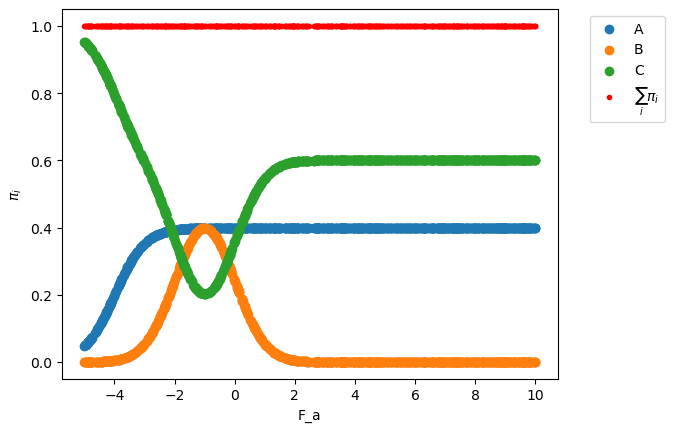

In [46]:
label=['A', 'B', 'C']
for i, species_labels in enumerate(train_labels.T):
    plt.scatter(train_features, species_labels, label=f'{label[i]}')
plt.scatter(train_features, np.sum(train_labels, axis=1), color='r', marker='.', label=r'$\sum_i \pi_i$')
plt.xlabel('F_a')
plt.ylabel(r'$\pi_i$')
plt.legend(bbox_to_anchor=[1.05, 1], loc='upper left')
plt.savefig('data/train_features.png', dpi=300, bbox_inches='tight')


Plotting the loss (currently 800 training points, online training, 3 batches).

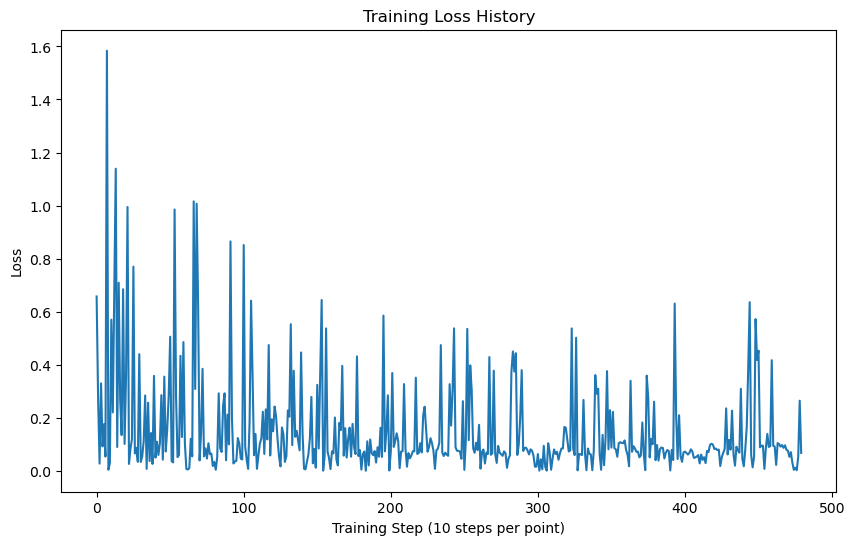

In [47]:
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Training Step (10 steps per point)')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.savefig('data/loss_history.png')  

In [48]:
init_labels=[]
for feature in val_features:
    all_params=jnp.append(initial_params, feature)
    solution = rxn.integrate(solver=Tsit5(), stepsize_controller=PIDController(0.005, 0.01), t_points=t_points, dt0=0.001, initial_conditions=initial_conditions, args=all_params, max_steps=10000)
    init_labels.append(solution.ys[-1].copy())

In [49]:
init_labels=jnp.exp(jnp.array(init_labels))

Plotting profiles using the true, initial, and optimized parameters. 

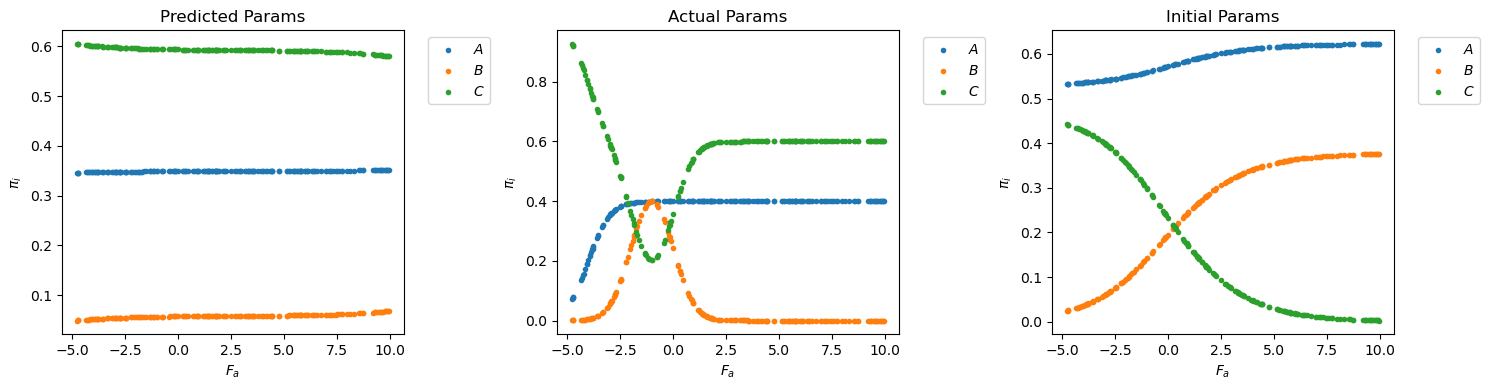

In [50]:
cmap = plt.colormaps['tab10']
colors = cmap(np.linspace(0, 1, 10))
fig=plt.figure(figsize=(15, 4))
gs=fig.add_gridspec(1, 3)

pred_ax=fig.add_subplot(gs[0, 0])
val_ax=fig.add_subplot(gs[0, 1])
init_ax=fig.add_subplot(gs[0, 2])

pred_ax.set_title('Predicted Params')
val_ax.set_title('Actual Params')
init_ax.set_title('Initial Params')

for i, species in enumerate(label):
    #plot the predicted and actual labels as a function of the feature
    
    #exponentiate if using EX 5
    pred_ax.scatter(val_features, pred_labels.T[i], label=f'${species}$', color=colors[i], marker='.')
    val_ax.scatter(val_features, val_labels.T[i], label=f'${species}$', color=colors[i], marker='.')
    init_ax.scatter(val_features, init_labels.T[i], label=f'${species}$', color=colors[i], marker='.')

pred_ax.set_xlabel(r'$F_a$')
pred_ax.set_ylabel(r'$\pi_i$')

val_ax.set_xlabel(r'$F_a$')
val_ax.set_ylabel(r'$\pi_i$')

init_ax.set_xlabel(r'$F_a$')
init_ax.set_ylabel(r'$\pi_i$')

pred_ax.legend(bbox_to_anchor=[1.05, 1], loc='upper left')
val_ax.legend(bbox_to_anchor=[1.05, 1], loc='upper left')
init_ax.legend(bbox_to_anchor=[1.05, 1], loc='upper left')

fig.tight_layout()
fig.savefig('data/predicted_and_optimized_profiles.png')

Calculating W_ij parameters to compare optimal to true.

In [34]:
def compute_W_ijs(params):
    E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=params
    F_BC_in=0
    F_CB_in=-F_BC_in
    F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

    F_BA=-F_AB
    F_CA=-F_AC
    F_CB=-F_BC

    #jax.debug.print('params:{params}', params=params)
    W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
    W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
    W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
    W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
    W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
    W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

    return jnp.array([W_AB, W_AC, W_BC, W_BA, W_CA, W_CB])

In [35]:
init_W_ijs=compute_W_ijs(initial_params)
optimized_W_ijs=compute_W_ijs(optimized_params)
true_W_ijs=compute_W_ijs(true_params)

In [36]:
jax.debug.print('Initial W_ijs: {x}', x=init_W_ijs)
jax.debug.print('Optimized W_ijs: {x}', x=optimized_W_ijs)
jax.debug.print('True W_ijs: {x}', x=true_W_ijs)

Initial W_ijs: [1.28402542 1.28402542 1.28402542 0.77880078 0.77880078 0.77880078]
Optimized W_ijs: [8.90373690e-01 1.31292472e+00 9.86185437e-04 1.44309679e+00
 3.95707225e+00 1.17865918e-02]
True W_ijs: [ 1.    1.    0.05 10.    0.1   4.  ]


# Autodiff vs FDE

compare gradients from fde and autodiff

In [143]:
file = open('data/triangle b/grads_per_epoch_autodiff', 'rb')
grads_per_epoch_autodiff=pkl.load(file)
file.close()

file = open('data/triangle b/grads_per_epoch_fde', 'rb')
grads_per_epoch_fde=pkl.load(file)
file.close()

In [144]:
params=['E_AB', 'B_AB', 'F_AB', 'E_BA', 'B_BA', 'F_BA', 'E_AC', 'B_AC', 'F_AC', 'E_CA', 'B_CA','F_CA', 'E_BC', 'B_BC', 'F_BC', 'E_CB', 'B_CB', 'F_CB']

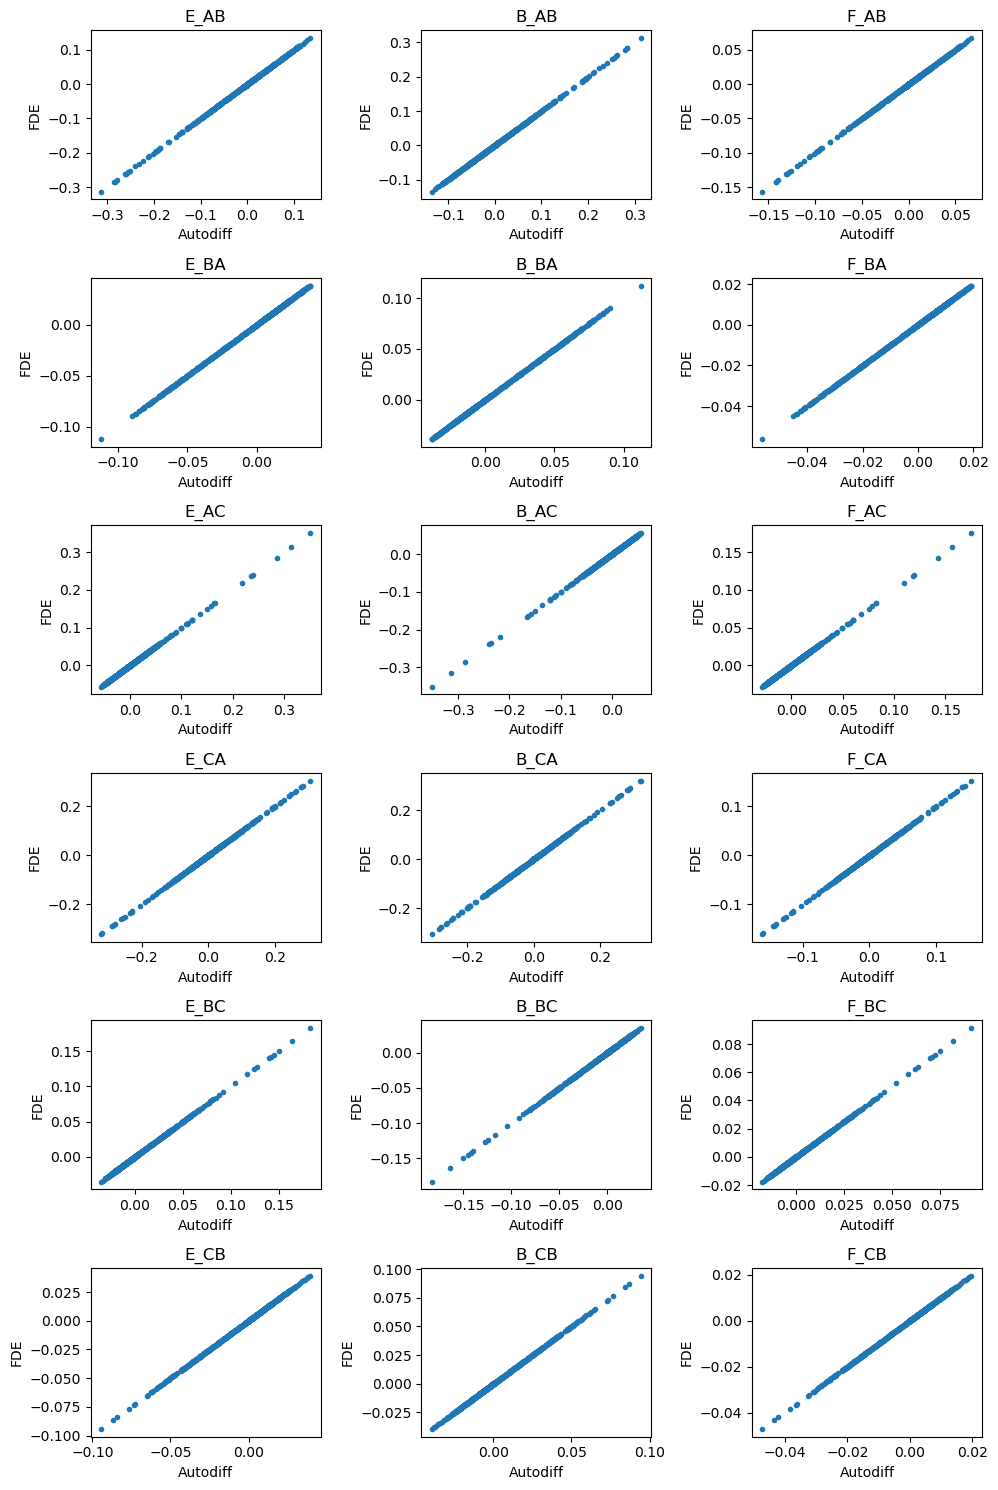

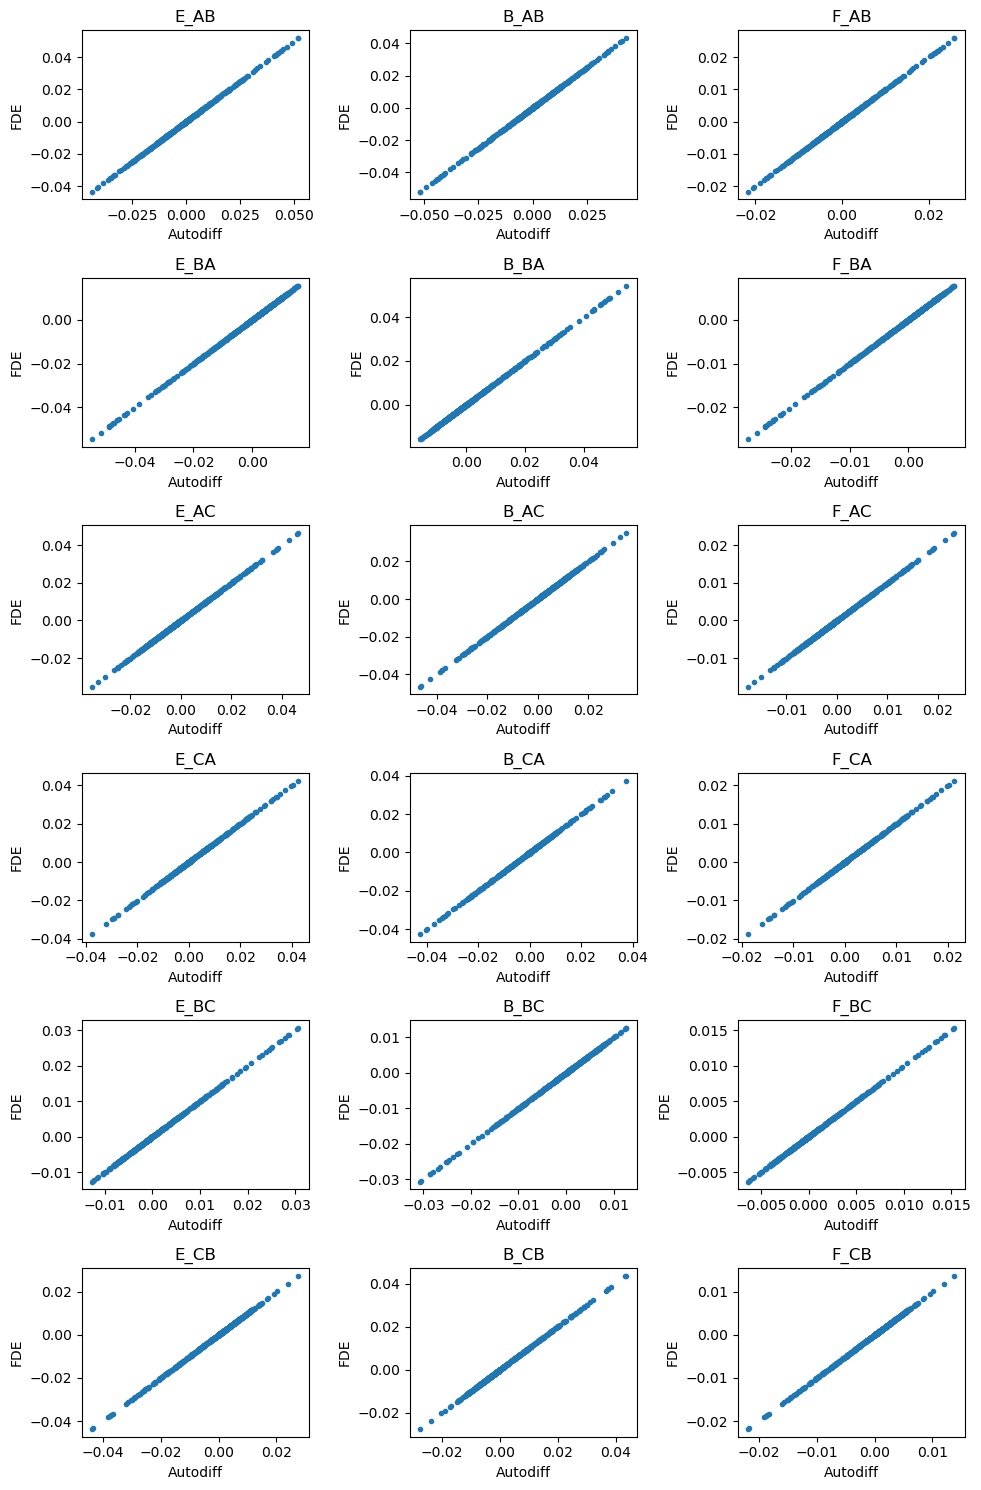

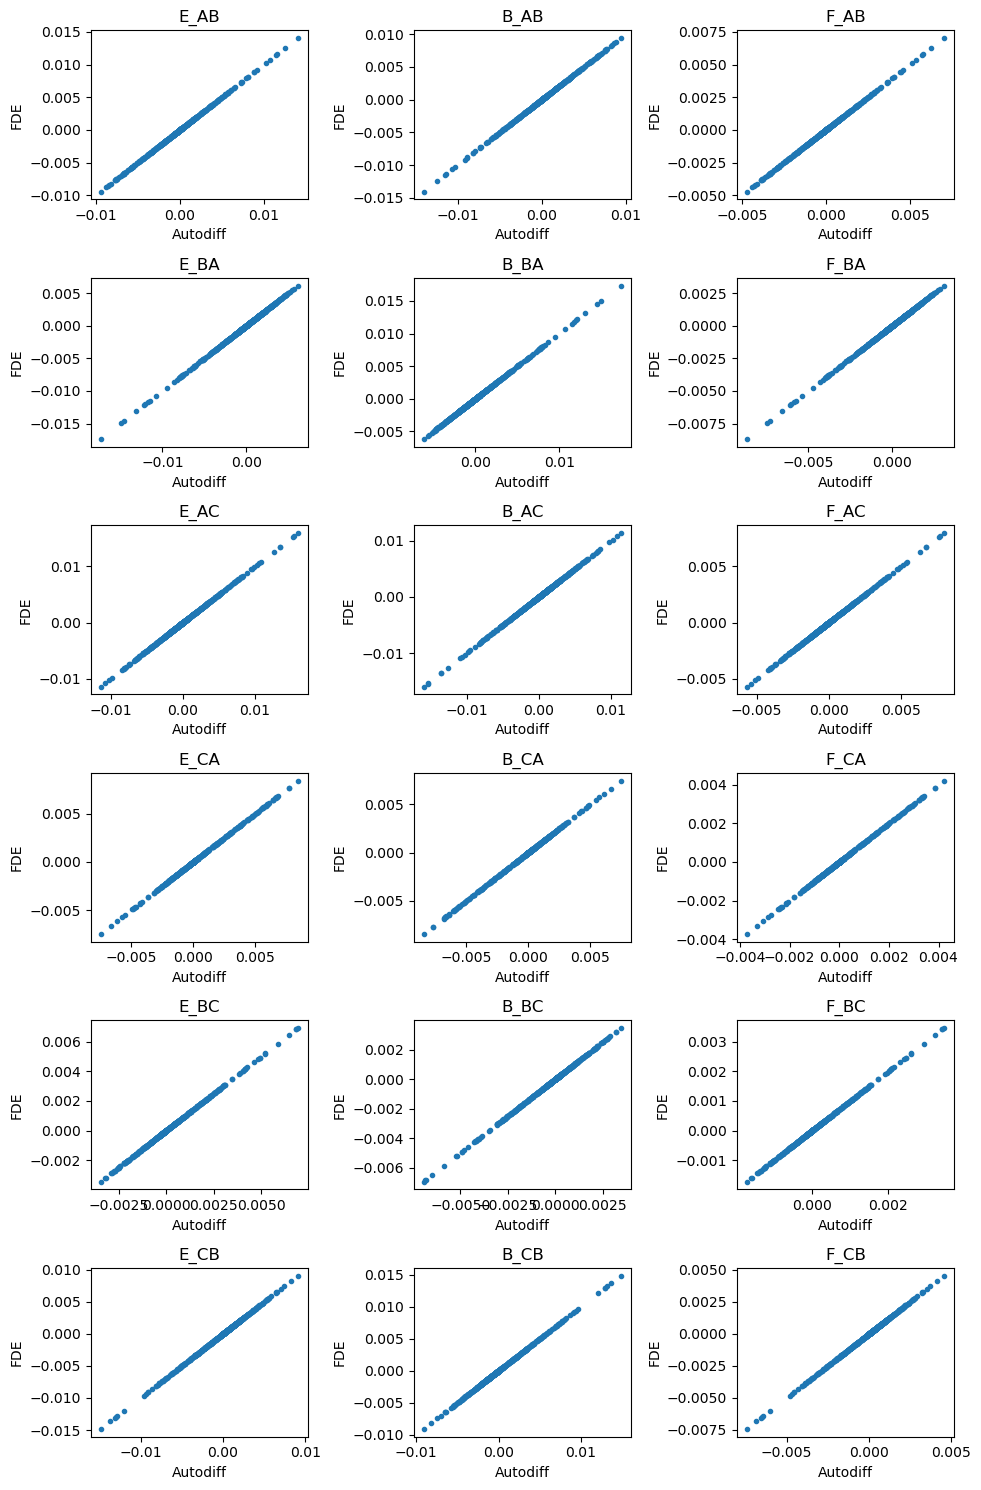

In [146]:
for  epoch in grads_per_epoch_autodiff.keys():

    fig =plt.figure(figsize=(10, 15))
    gs = fig.add_gridspec(6, 3)

    epoch_grads_autodiff=np.array(grads_per_epoch_autodiff[epoch])
    epoch_grads_fde=np.array(grads_per_epoch_fde[epoch])

    #plot autodiff vs fde grads for each param 
    for i, data in enumerate(zip(epoch_grads_autodiff.T, epoch_grads_fde.T)):
        ad, fde =data
        ax_subplot = fig.add_subplot(gs[i//3, i%3]) 
        ax_subplot.scatter(ad, fde, marker='.')
        ax_subplot.set_title(f'{params[i]}')
        ax_subplot.set_xlabel('Autodiff')
        ax_subplot.set_ylabel('FDE')

    fig.tight_layout()
    fig.savefig(f'data/autodiff_vs_fde_epoch_{epoch}.png')

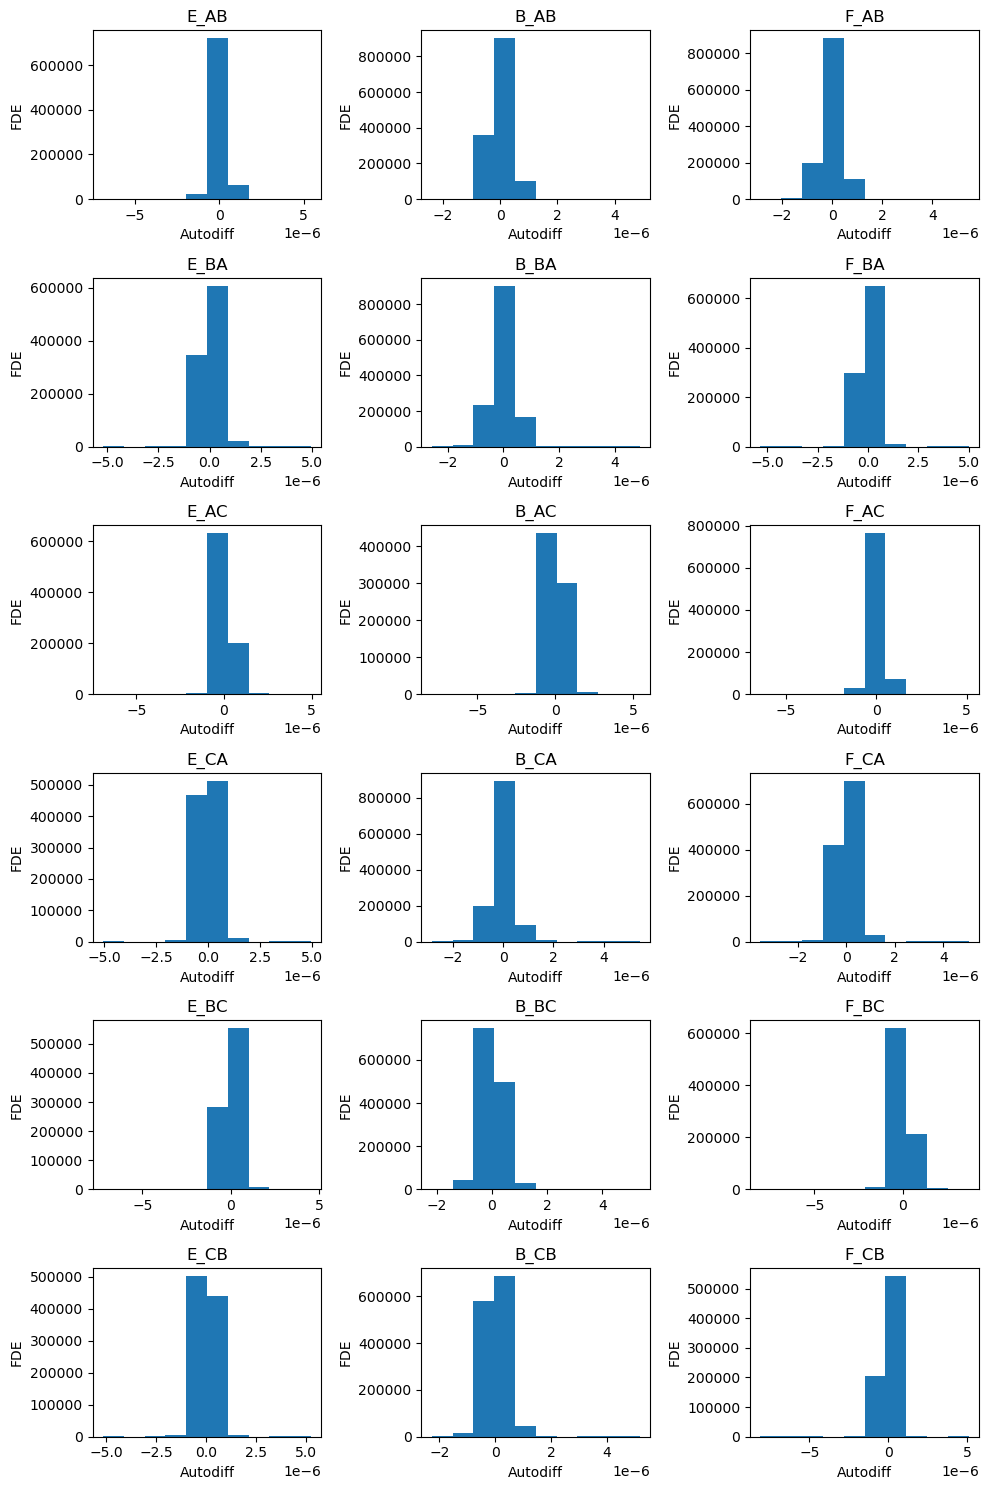

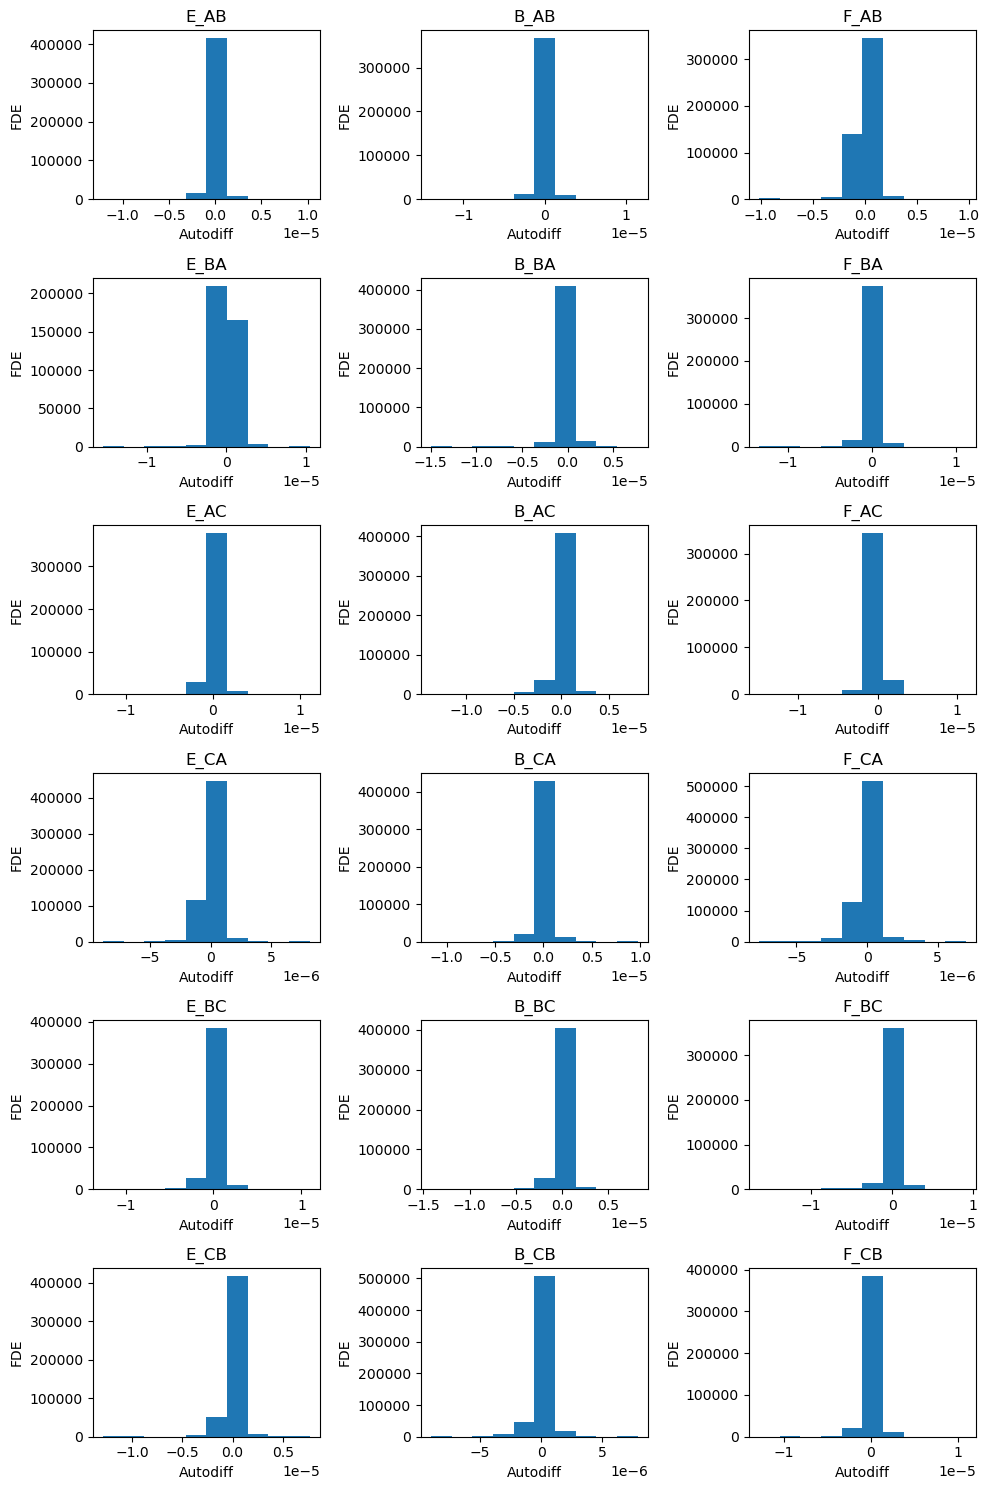

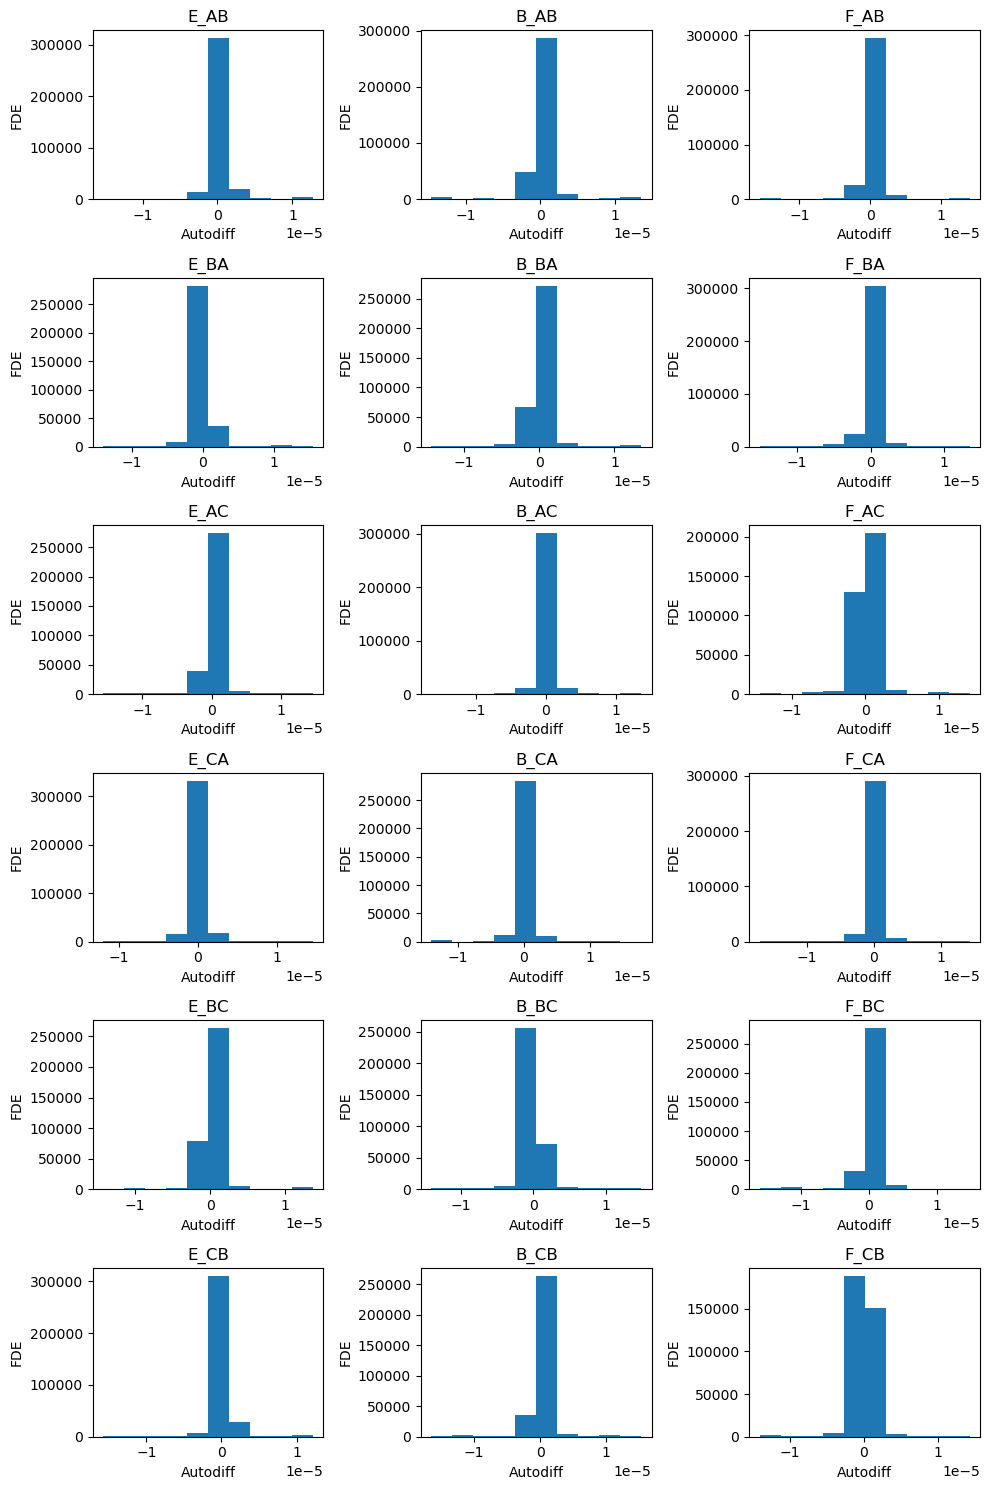

In [150]:
for  epoch in grads_per_epoch_autodiff.keys():

    fig =plt.figure(figsize=(10, 15))
    gs = fig.add_gridspec(6, 3)

    epoch_grads_autodiff=np.array(grads_per_epoch_autodiff[epoch])
    epoch_grads_fde=np.array(grads_per_epoch_fde[epoch])

    #plot autodiff vs fde grads for each param 
    for i, data in enumerate(zip(epoch_grads_autodiff.T, epoch_grads_fde.T)):
        ad, fde =data
        ax_subplot = fig.add_subplot(gs[i//3, i%3]) 
        ax_subplot.hist(ad-fde, density=True)
        ax_subplot.set_title(f'{params[i]}')
        ax_subplot.set_xlabel('Autodiff')
        ax_subplot.set_ylabel('FDE')

    fig.tight_layout()
    fig.savefig(f'data/autodiff_fde_hist_epoch_{epoch}.png')

In [ ]:
'''
file = open('data/triangle b fde/train_features', 'rb')
train_features=pkl.load(file)
file.close()

file = open('data/triangle b fde/train_labels', 'rb')
train_labels=pkl.load(file)
file.close()

file = open('data/triangle b fde/val_features', 'rb')
val_features=pkl.load(file)
file.close()

file = open('data/triangle b fde/val_labels', 'rb')
val_labels=pkl.load(file)
file.close()

file = open('data/triangle b fde/pred_labels', 'rb')
pred_labels=pkl.load(file)
file.close()

file = open('data/triangle b fde/optimized_params', 'rb')
opt_params=pkl.load(file)
file.close()

file = open('data/triangle b fde/loss_history', 'rb')
loss_history=pkl.load(file)
file.close()
'''